In [1]:
from scipy.io import loadmat
import numpy as np
import os
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt

In [2]:
# Expectation (prior): tr_exp = 1, tr_neu = 2, tr_unexp = 3

# Attention (attCue): tr_for = 1, tr_div = 2
# div -> -1, for -> 1

# Coherence (tgCoh): tr_lo = 1, tr_hi = 2
# low -> -1, high -> 1

# Observation (response_angle)

# Target = stimDirREAL
# Coherece oriantation = EXP_ORI[p.expOri]
# Coherence strength = tgCoh
# Attention state = attCue
# bias = np.ones

In [3]:
# Set in stone
PATH_DS = '../axej_eeg'
cali_path = '../axej_eeg_calibrations/'
EXP_ORI = [159, 123, 87, 51, 15]
SUBS = 13
SESS = 4
RUNS = 6

# Index combinations at 3 levels with ittertools
subjects = ["01", "02", "03", "04", "05", "06", "07", "08" ,"09", "10", "11", "12", "14"]
data_idx = list(itertools.product(range(SUBS), range(SESS), range(RUNS)))
# all_files = sorted(os.listdir(cali_path))

In [4]:
# Indexer
class Subjects:
    class Sessions:
        class Runs:
            def __init__(self, paths) -> None:
                self.paths = sorted(paths, key= lambda x: int(x.split('_')[-1][3]))

            def __getitem__(self, run_idx):
                return self.load_data(self.paths[run_idx])
            
            def load_data(self, path):
                mat_contents = loadmat(path, struct_as_record=False, squeeze_me=True)
                return mat_contents["p"].__dict__

        def __init__(self, path) -> None:
            self.base_path = os.path.join(path, "runs")
            self.sess_paths = sorted(os.listdir(self.base_path), key= lambda x: int(x.split('_')[2][1]))
            self.sess_paths = [os.path.join(self.base_path, path) for path in self.sess_paths]
            self.sess_paths = [self.sess_paths[i:i+6] for i in range(0, len(self.sess_paths), 6)]

        def __getitem__(self, sess_idx):
            return self.Runs(self.sess_paths[sess_idx])

    def __init__(self, path) -> None:
        self.path = path
        self.subj_paths = sorted(os.listdir(path), key=lambda x: int(x.split('j')[1]))

    def __getitem__(self, sub_idx):
        return self.Sessions(os.path.join(self.path, self.subj_paths[sub_idx]))

# Refresher
def np_refresh(np_array): return np.array(np_array.tolist()).astype("float")

def make_responses(jx, jy):
    dist_from_cent = np.sqrt(jx ** 2 + jy ** 2)
    dist_from_cent[np.isnan(dist_from_cent)] = 0
    max_idx = np.argmax(dist_from_cent, axis=3)

    max_x = jx[np.arange(4)[:, np.newaxis, np.newaxis], np.arange(5)[:, np.newaxis], np.arange(120), max_idx]
    max_y = jy[np.arange(4)[:, np.newaxis, np.newaxis], np.arange(5)[:, np.newaxis], np.arange(120), max_idx]

    resp_angle = np.arctan2(max_y, max_x)
    resp_angle = np.rad2deg(resp_angle)

    return resp_angle, max_idx

def get_calib(subj = 1, sess = 1):
    mat_contents = loadmat(cali_path + f'AxeJEEG_Subj{subjects[subj]}_S{sess+1}_Cali1.mat.mat', struct_as_record=False, squeeze_me=True)
    return mat_contents["p"].__dict__

In [5]:
subj_loader = Subjects(PATH_DS)


# data = subj_loader[0][0][0]
# calib_data = get_calib(1,1)

In [6]:
shape = (SUBS, SESS)
cali_jx = np.ndarray(shape=shape, dtype=object)
cali_jy = np.ndarray(shape=shape, dtype=object)
cali_sti_dir = np.ndarray(shape=shape, dtype=object)

for sub_idx in range(SUBS):
    for sess_idx in range(SESS):
        cali_data = get_calib(sub_idx, sess_idx)
        cali_jx[sub_idx, sess_idx] = cali_data["joyx"]
        cali_jy[sub_idx, sess_idx] = cali_data["joyy"]
        cali_sti_dir[sub_idx, sess_idx] = cali_data["stimDirREAL"]

cali_jx = np_refresh(cali_jx)
cali_jy = np_refresh(cali_jy)

cali_sti_dir = np_refresh(cali_sti_dir)

In [7]:
cali_jx.shape, cali_jy.shape, cali_sti_dir.shape

((13, 4, 120, 500), (13, 4, 120, 500), (13, 4, 120))

In [8]:
# jx = cali_jx
# jy = cali_jy

# dist_from_cent = np.sqrt(jx ** 2 + jy ** 2)
# dist_from_cent[np.isnan(dist_from_cent)] = 0
# max_idx = np.argmax(dist_from_cent, axis=3)

# max_x = jx[np.arange(4)[:, np.newaxis, np.newaxis], np.arange(5)[:, np.newaxis], np.arange(120), max_idx]
# max_y = jy[np.arange(4)[:, np.newaxis, np.newaxis], np.arange(5)[:, np.newaxis], np.arange(120), max_idx]

# resp_angle = np.arctan2(max_y, max_x)
# resp_angle = np.rad2deg(resp_angle)

In [9]:
# dist_from_cent.shape

In [10]:
cali_resp_angle = np.arctan2( cali_jy.flatten(), cali_jx.flatten() )
cali_resp_angle = np.rad2deg(cali_resp_angle)
cali_resp_angle = (cali_resp_angle + 360) % 360;
cali_resp_angle = cali_resp_angle.reshape(13,4,120,500)

cali_resp_angle.shape

(13, 4, 120, 500)

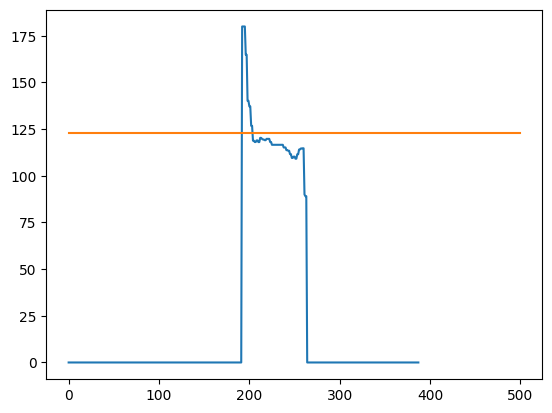

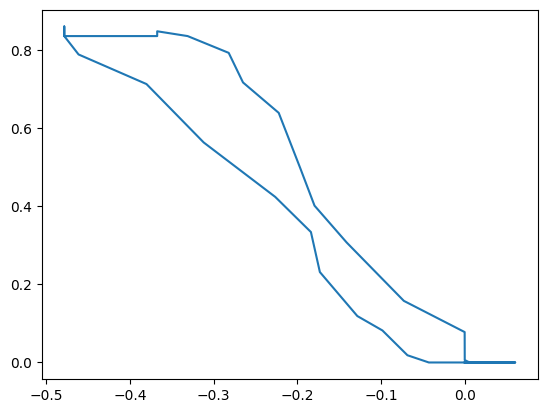

In [11]:
run = 14
plt.plot(cali_resp_angle[5,0,run,:])
plt.plot(cali_sti_dir[5,0,run]*np.ones(500))
plt.show()
plt.plot(cali_jx[5,0,run,:], cali_jy[5,0,run,:])
plt.show()

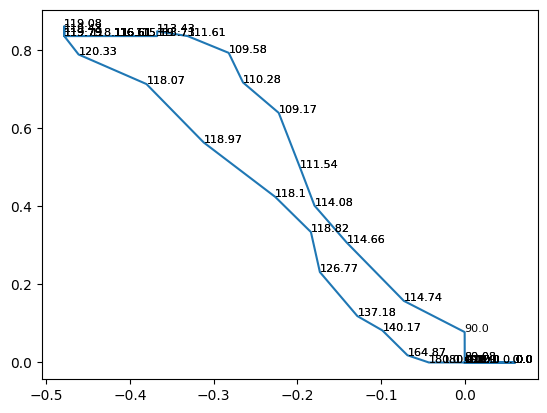

In [12]:
run = 14

plt.plot(cali_jx[5,0,run,:], cali_jy[5,0,run,:])
# at each point in the plot, write the corresponding response angle
for i in range(500):

    # skip if not a number
    if np.isnan(cali_jx[5,0,run,i]):
        continue

    plt.text(cali_jx[5,0,run,i], cali_jy[5,0,run,i], str(round(cali_resp_angle[5,0,run,i], 2)), fontsize=8)
plt.show()

In [13]:
cali_sti_dir.shape

(13, 4, 120)

In [14]:
shape = (SUBS, SESS)
cali_jx = np.ndarray(shape=shape, dtype=object)
cali_jy = np.ndarray(shape=shape, dtype=object)
cali_sti_dir = np.ndarray(shape=shape, dtype=object)

for sub_idx in range(SUBS):
    for sess_idx in range(SESS):
        cali_data = get_calib(sub_idx, sess_idx)
        cali_jx[sub_idx, sess_idx] = cali_data["joyx"]
        cali_jy[sub_idx, sess_idx] = cali_data["joyy"]
        cali_sti_dir[sub_idx, sess_idx] = cali_data["stimDirREAL"]

cali_jx = np_refresh(cali_jx)
cali_jy = np_refresh(cali_jy)

cali_sti_dir = np_refresh(cali_sti_dir)

In [15]:
dist_from_cent = np.sqrt(cali_jx ** 2 + cali_jy ** 2)
dist_from_cent[np.isnan(dist_from_cent)] = 0

In [16]:
max_idx = np.argmax(dist_from_cent, axis=-1)

In [17]:
max_idx.shape

(13, 4, 120)

In [18]:
dist_from_cent.shape

(13, 4, 120, 500)

In [19]:
cali_jx.shape, cali_jy.shape, cali_sti_dir.shape

((13, 4, 120, 500), (13, 4, 120, 500), (13, 4, 120))

In [20]:

su = []
for sub_idx in range(SUBS):
    se = []
    for sess_idx in range(SESS):
        tr = []
        for trial_idx in range(120):
            max_x = cali_jx[sub_idx, sess_idx, trial_idx, max_idx[sub_idx, sess_idx, trial_idx]]
            max_y = cali_jy[sub_idx, sess_idx, trial_idx, max_idx[sub_idx, sess_idx, trial_idx]]

            resp_angle = np.arctan2(max_y, max_x)
            resp_angle = np.rad2deg(resp_angle)
            resp_angle = (resp_angle + 360) % 360;

            tr.append(resp_angle)
        se.append(tr)
    su.append(se)

su = np.array(su)


In [21]:
su.shape

(13, 4, 120)

In [22]:
su[0,0]

array([135.        ,  52.24221797, 135.        , 135.        ,
       135.        ,  76.86235525,  37.44128061,  66.95024734,
        45.        ,  33.82208522,  45.        ,  59.28545315,
        72.68252145,  68.68427074, 135.        ,  45.        ,
        45.        , 135.        ,  45.        ,  36.58280463,
        20.1632351 ,  45.        ,  64.52220035,  72.68252145,
        45.        , 135.        , 135.        ,  68.68427074,
       135.        , 135.        , 135.        ,  32.00538321,
       135.        , 135.        , 135.        , 135.        ,
       135.        ,  62.71984207,  45.        ,  45.        ,
       135.        ,  18.16983594,  27.63205745,  45.        ,
       135.        ,  45.        , 135.        ,  79.66288786,
        83.4002232 ,  32.00538321, 135.        , 135.        ,
        24.00819125, 135.        , 135.        ,  45.        ,
        62.71984207, 135.        , 135.        ,  34.50852299,
        24.00819125,  29.35775354,  62.01382334, 135.  

In [23]:
max_idx[0,0]

array([256, 294, 262, 297, 326, 303, 314, 314, 212, 316, 277, 241, 301,
       309, 291, 268, 288, 230, 212, 338, 266, 286, 277, 307, 267, 289,
       256, 251, 290, 267, 269, 286, 252, 257, 284, 271, 230, 292, 280,
       315, 246, 306, 290, 255, 229, 247, 282, 278, 305, 318, 280, 254,
       262, 276, 282, 293, 271, 286, 283, 275, 315, 286, 319, 229, 294,
       261, 244, 245, 238, 258, 269, 237, 275, 321, 257, 261, 275, 307,
       327, 258, 310, 273, 322, 313, 280, 338, 283, 258, 304, 277, 285,
       266, 271, 291, 298, 293, 285, 303, 256, 277, 265, 282, 310, 233,
       277, 284, 264, 288, 355, 274, 291, 263, 281, 272, 270, 291, 316,
       249, 214, 279])

In [24]:
dist_from_cent[0,0,0,256]

1.4142135623730951

In [25]:
dist_from_cent[0,0,0,262]

1.4142135623730951

In [26]:
cali_sti_dir.shape

(13, 4, 120)

In [27]:
np.unique(cali_sti_dir[0,0], return_counts=True)

(array([ 15.,  51.,  87., 123., 159.]), array([24, 24, 24, 24, 24]))

In [28]:
su[cali_sti_dir == 159.].reshape(13,4,24)

array([[[135.        , 135.        , 135.        , ..., 135.        ,
         135.        , 135.        ],
        [135.        , 135.        , 135.        , ..., 135.        ,
         135.        , 136.13933751],
        [135.        , 135.        , 136.4326831 , ..., 135.        ,
         135.        , 135.        ],
        [135.        , 135.        , 135.        , ..., 135.        ,
         135.        , 135.        ]],

       [[135.        , 135.        , 135.        , ..., 135.        ,
         135.        , 135.        ],
        [135.        , 135.        , 135.        , ..., 135.        ,
         135.        , 135.        ],
        [135.        , 135.        , 135.        , ..., 135.        ,
         135.        , 135.        ],
        [135.        , 135.        , 135.        , ..., 135.        ,
         135.        , 135.        ]],

       [[135.        , 135.        , 135.        , ..., 138.06030563,
         135.        , 135.        ],
        [346.86235525, 1

In [29]:
cali_5 = su[cali_sti_dir == 159.].reshape(13,4,24)
cali_4 = su[cali_sti_dir == 123.].reshape(13,4,24)
cali_3 = su[cali_sti_dir == 87.].reshape(13,4,24)
cali_2 = su[cali_sti_dir == 51.].reshape(13,4,24)
cali_1 = su[cali_sti_dir == 15.].reshape(13,4,24)

In [30]:
# circular mean

def circ_mean(angles, axis=None):

    # convert to radians
    angles = np.deg2rad(angles)

    # get sin and cos of angles
    sin = np.sin(angles)
    cos = np.cos(angles)

    # sum them
    sum_sin = np.sum(sin, axis=axis)
    sum_cos = np.sum(cos, axis=axis)

    # get angle from sin and cos
    mean_angle = np.arctan2(sum_sin, sum_cos)

    return np.rad2deg(mean_angle)
    


In [31]:
cali_5.shape

(13, 4, 24)

In [32]:
mean_cali_5 = circ_mean(cali_5, axis=2)

In [33]:
mean_cali_4 = circ_mean(cali_4, axis=2)
mean_cali_3 = circ_mean(cali_3, axis=2)
mean_cali_2 = circ_mean(cali_2, axis=2)
mean_cali_1 = circ_mean(cali_1, axis=2)

In [34]:
mean_cali_5 # 159 deg representation 13 subjects 4 sessions

array([[135.        , 135.34598815, 135.05968966, 135.01876696],
       [135.        , 135.        , 135.        , 135.        ],
       [135.69794737, 146.82245543, 142.16701181, 143.88604123],
       [141.99568508, 137.30369873, 145.94510739, 140.83739428],
       [155.61411697, 127.38069002, 151.92284518, 151.7545526 ],
       [157.32951785, 150.27993331, 151.51172599, 143.18813985],
       [128.7053662 , 132.4902683 , 135.99769717, 136.45902158],
       [149.60600088, 143.21939811, 143.04943283, 132.23558893],
       [161.24716471, 156.85192338, 150.53516416, 144.06591758],
       [149.62436449, 130.44570123, 143.57868789, 147.84870617],
       [155.28056156, 146.70133568, 146.73018475, 144.71730052],
       [177.80426138, 179.14961082, 176.74247835, 177.55647338],
       [148.21524147, 147.21711778, 149.89524599, 159.66779921]])

In [35]:
mean_cali_4 # 123 deg representation 13 subjects 4 sessions

array([[134.14202406, 135.        , 134.53744099, 134.96246604],
       [134.72622038, 135.        , 131.1665486 , 131.18232228],
       [133.11574288, 120.56954131, 128.5352963 , 126.03292429],
       [115.18978396, 134.48247704, 118.89359137, 113.3074398 ],
       [145.32448743, 131.48674692, 145.0906119 , 135.41366096],
       [129.48593675, 124.74335079, 130.57434803, 125.41960679],
       [117.34849375, 116.29981886, 123.35489985, 122.17593912],
       [129.4286001 , 118.34904795, 121.25901798, 114.9184257 ],
       [123.6941482 , 121.90376855, 120.23011382, 116.32606612],
       [126.32248707, 113.68680285, 130.78469792, 135.73853446],
       [141.53487105, 135.39354326, 127.52222773, 129.80812028],
       [141.33003623, 145.40919109, 137.30177857, 134.75570844],
       [134.02900558, 133.65984192, 135.97007989, 149.25271179]])

In [36]:
mean_cali_3 # 87 deg representation 13 subjects 4 sessions

array([[ 68.94671459,  56.51927678,  56.16796327,  59.64606811],
       [ 64.77749844,  61.18526264,  69.56848077,  61.97399237],
       [ 59.64028455,  87.2935769 ,  84.05620922,  77.65762616],
       [ 87.48192304,  89.27318579,  90.4332624 ,  85.70032557],
       [ 80.13955356,  63.68197184,  79.89337382,  63.91192097],
       [ 72.01859659,  72.44437932,  62.48709067,  61.02943641],
       [ 75.71338726,  71.85460904,  78.18897049,  79.5030139 ],
       [ 86.44866618,  76.93791071,  82.72623077,  81.81880786],
       [ 79.36709746,  74.3831103 ,  71.62042977,  70.54723614],
       [ 86.2722625 ,  75.58172964,  92.28058323, 107.44210099],
       [ 68.76407406,  64.52110605,  66.51998301,  68.87700782],
       [ 88.50677263,  97.17373652,  90.25363392,  82.05495832],
       [ 90.2509032 ,  85.78187112,  85.8545139 ,  95.611994  ]])

In [37]:
mean_cali_2 # 51 deg representation 13 subjects 4 sessions

array([[44.91065   , 44.64566494, 45.        , 45.        ],
       [46.74409151, 45.05257364, 51.11193457, 46.47977092],
       [47.10169808, 62.02615819, 60.82558211, 54.18314512],
       [48.30308208, 45.        , 47.26518608, 56.8280073 ],
       [46.20795436, 49.48885551, 36.06177182, 25.86448002],
       [44.79085607, 46.36155286, 39.601203  , 38.36016594],
       [46.39649643, 40.71614489, 41.82107706, 51.79079484],
       [40.24711241, 36.97289873, 39.06587157, 41.70267578],
       [37.7131799 , 36.30306458, 45.11645934, 44.54179746],
       [36.80354689, 39.32889989, 59.78605767, 52.43079734],
       [26.78283853, 28.43413677, 32.5000358 , 27.59284556],
       [27.90600497, 40.22745911, 38.41022021, 31.27151998],
       [39.0169448 , 35.56956968, 37.82938838, 46.35939883]])

In [38]:
mean_cali_1 # 15 deg representation 13 subjects 4 sessions

array([[29.42544132, 29.75801207, 32.82798057, 30.04549932],
       [39.79160874, 44.9391474 , 47.4192364 , 36.29123414],
       [30.097476  ,  9.8469744 , 26.46030952, 22.93907137],
       [24.12931484, 30.48012126, 11.49835315, 29.14886524],
       [26.7501958 , 41.5187798 , 24.97271897, 10.53761728],
       [12.92958357, 26.15362782, 24.7672078 , 23.2364437 ],
       [36.74014183, 26.69987926, 30.92376926, 34.18199834],
       [15.10539733, 14.39598079, 21.47902586, 25.66431514],
       [ 0.34294405,  2.74145111,  9.2608841 ,  4.21173323],
       [13.85489616, 18.6270913 , 31.55833067, 28.46915093],
       [ 6.90829959,  7.78655845,  4.16041488,  9.09987508],
       [ 1.42159623,  6.16899849,  4.58834249, -1.16432808],
       [11.46705395,  3.25186427,  5.54171214, 11.45675995]])

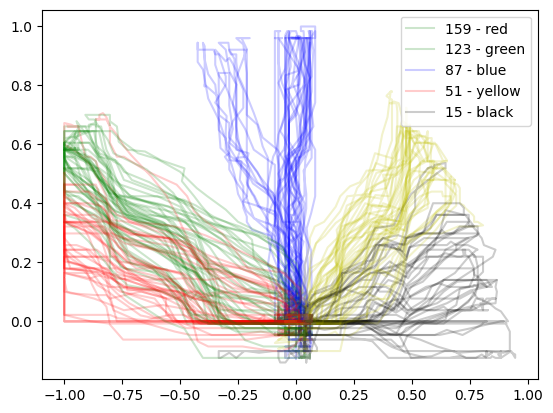

In [39]:
sub = 12
ses = 3

for i in range(120): 
    if cali_sti_dir[sub,ses,i] == 159.0:
        color = 'r'
    elif cali_sti_dir[sub,ses,i] == 123.0:
        color = 'g'
    elif cali_sti_dir[sub,ses,i] == 87.0:
        color = 'b'
    elif cali_sti_dir[sub,ses,i] == 51.0:
        color = 'y'
    elif cali_sti_dir[sub,ses,i] == 15.0:
        color = 'k'

    plt.plot(cali_jx[sub,ses,i,:], cali_jy[sub,ses,i,:], '-', color=color, alpha=0.2)

plt.legend(['159 - red', '123 - green', '87 - blue', '51 - yellow', '15 - black'])

plt.show()

In [40]:
cali_sti_dir

array([[[159.,  87., 123., ...,  15.,  51., 159.],
        [ 15.,  15.,  51., ...,  51., 159.,  51.],
        [159., 123.,  87., ...,  51.,  87.,  51.],
        [ 87.,  51., 159., ...,  87.,  15., 123.]],

       [[ 87.,  15.,  15., ..., 123.,  15.,  15.],
        [159., 123.,  15., ...,  87., 123.,  51.],
        [159.,  87.,  87., ..., 123.,  51., 123.],
        [159.,  87.,  15., ...,  87., 123., 123.]],

       [[ 87., 123.,  51., ...,  15.,  51.,  51.],
        [ 51.,  15., 123., ...,  15.,  87.,  87.],
        [ 87., 159.,  87., ...,  51., 159., 159.],
        [ 87.,  51.,  15., ...,  87.,  15.,  87.]],

       ...,

       [[ 15., 159., 123., ..., 123.,  51., 123.],
        [ 15.,  51.,  87., ...,  51., 123.,  15.],
        [159., 159., 159., ...,  51., 123.,  87.],
        [ 87.,  51.,  87., ..., 123.,  51.,  15.]],

       [[123., 123.,  51., ..., 123., 159.,  51.],
        [ 87.,  87.,  51., ...,  15.,  51.,  87.],
        [123.,  15., 123., ..., 123., 123., 159.],
        [ 

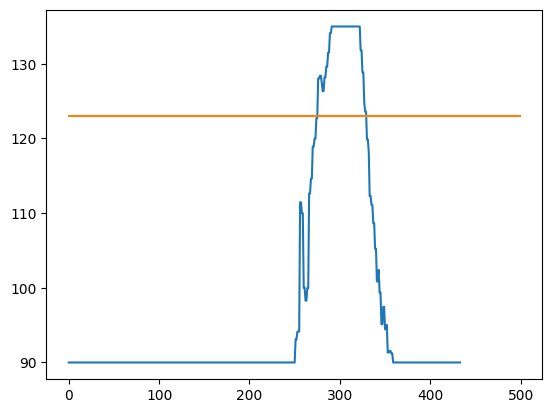

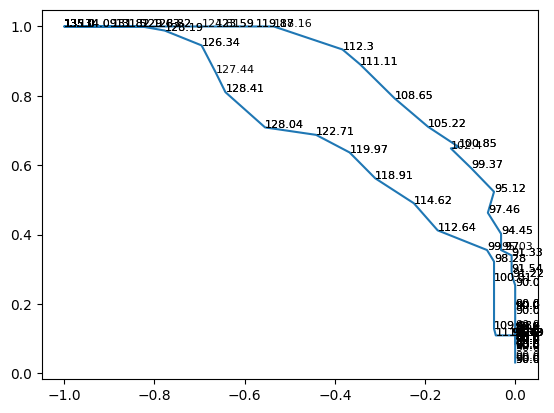

In [41]:
sub = 0
sess = 0
run = 14

plt.plot(cali_resp_angle[sub,sess,run,:])
plt.plot(cali_sti_dir[sub,sess,run]*np.ones(500))
plt.show()

plt.plot(cali_jx[sub,sess,run,:], cali_jy[sub,sess,run,:])
# at each point in the plot, write the corresponding response angle
for i in range(500):

    # skip if not a number
    if np.isnan(cali_jx[sub,sess,run,i]):
        continue

    plt.text(cali_jx[sub,sess,run,i], cali_jy[sub,sess,run,i], str(round(cali_resp_angle[sub,sess,run,i], 2)), fontsize=8)
plt.show()

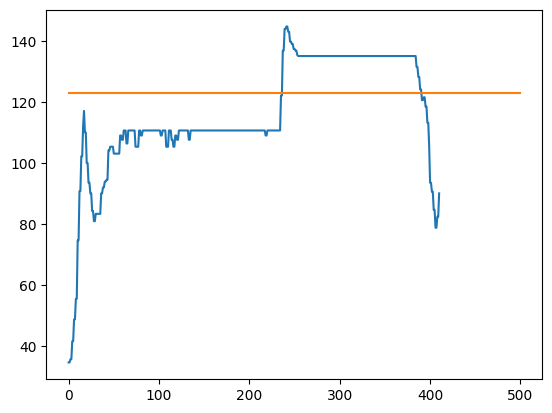

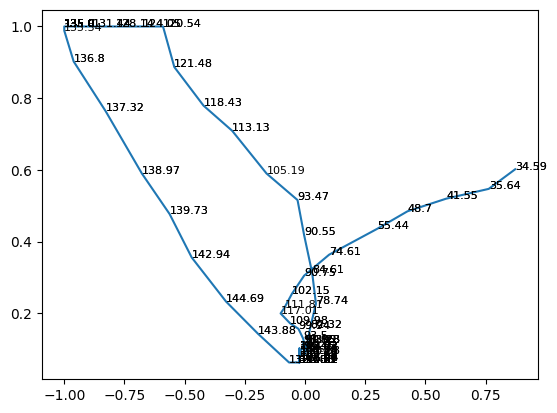

In [54]:
sub = 2
sess = 0
run = 3

plt.plot(cali_resp_angle[sub,sess,run,:])
plt.plot(cali_sti_dir[sub,sess,run]*np.ones(500))
plt.show()

plt.plot(cali_jx[sub,sess,run,:], cali_jy[sub,sess,run,:])
# at each point in the plot, write the corresponding response angle
for i in range(500):

    # skip if not a number
    if np.isnan(cali_jx[sub,sess,run,i]):
        continue

    plt.text(cali_jx[sub,sess,run,i], cali_jy[sub,sess,run,i], str(round(cali_resp_angle[sub,sess,run,i], 2)), fontsize=8)
plt.show()

In [43]:
shape = (SESS, RUNS - 1)

jx = np.ndarray(shape=shape, dtype=object)
jy = np.ndarray(shape=shape, dtype=object)
sti_dir = np.ndarray(shape=shape, dtype=object)
ori_dir = np.ndarray(shape=shape, dtype=object)
ori_st = np.ndarray(shape=shape, dtype=object)
att_st = np.ndarray(shape=shape, dtype=object)

subs = 5
for sess, runs in itertools.product(range(SESS), range(RUNS)):
    # Skip the last run with no expetation
    if runs == 5: continue
    data = subj_loader[subs][sess][runs]
    jx[sess, runs] = data['joyx']
    jy[sess, runs] = data['joyy']
    sti_dir[sess, runs] = data['stimDirREAL']
    ori_dir[sess, runs] = EXP_ORI[data['expOri'] - 1]
    ori_st[sess, runs] = data['tgCoh']
    att_st[sess, runs] = data['attCue']

jx = np_refresh(jx)
jy = np_refresh(jy)
sti_dir = np_refresh(sti_dir)
ori_dir = np_refresh(ori_dir)
ori_st = np_refresh(ori_st)
att_st = np_refresh(att_st)

# Repeat ori for each trial
ori_dir = np.expand_dims(ori_dir, axis=2)
ori_dir = np.repeat(ori_dir, 120, axis=2)

jx.shape, jy.shape

((4, 5, 120, 500), (4, 5, 120, 500))

In [44]:
sti_dir.shape, ori_dir.shape, ori_st.shape, att_st.shape

((4, 5, 120), (4, 5, 120), (4, 5, 120), (4, 5, 120))

In [45]:
resp_angle, resp_idx = make_responses(jx, jy)
resp_angle.shape, resp_idx.shape

((4, 5, 120), (4, 5, 120))

In [46]:
# replace all 2 with -1 for input_att_st
att_st[att_st == 2] = -1.0

ori_st[ori_st == 1] = -1.0
ori_st[ori_st == 2] = 1.0

In [47]:
resp_angle.shape, sti_dir.shape, ori_dir.shape, ori_st.shape, att_st.shape

((4, 5, 120), (4, 5, 120), (4, 5, 120), (4, 5, 120), (4, 5, 120))

In [48]:
import pandas as pd

df = pd.DataFrame({
    'resp_angle': resp_angle.flatten(),
    'sti_dir': sti_dir.flatten(),
    'ori_dir': ori_dir.flatten(),
    'ori_st': ori_st.flatten(),
    'att_st': att_st.flatten(),
})

In [49]:
# correct = resp_angle / sti_dir if resp_angle < sti_dir or else sti_dir / resp_angle
df["err"] = df["resp_angle"] - df["sti_dir"]
# make all errs positive
df["err"] = df["err"].abs()

In [50]:
df

,resp_angle,sti_dir,ori_dir,ori_st,att_st,err
0,61.577067,15.0,159.0,-1.0,-1.0,46.577067
1,151.275901,159.0,159.0,-1.0,-1.0,7.724099
2,31.758094,159.0,159.0,1.0,1.0,127.241906
3,109.971201,123.0,159.0,1.0,-1.0,13.028799
4,30.345199,159.0,159.0,-1.0,1.0,128.654801
...,...,...,...,...,...,...
2395,27.112446,15.0,15.0,-1.0,1.0,12.112446
2396,27.384157,15.0,15.0,1.0,-1.0,12.384157
2397,26.381411,15.0,15.0,1.0,1.0,11.381411
2398,28.191308,15.0,15.0,-1.0,-1.0,13.191308


<Axes: >

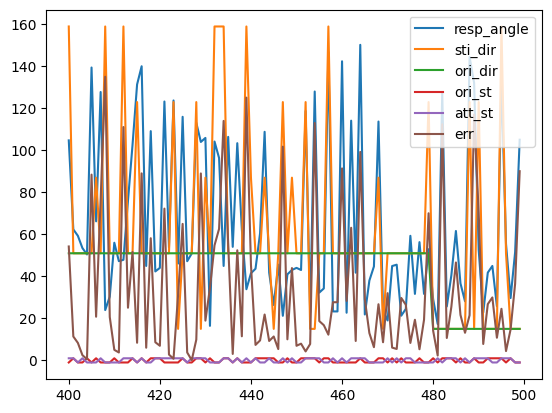

In [51]:
idx = 400
df[idx:idx+100].plot()

In [52]:
# group by attention state and average error

df.groupby("att_st").mean()["err"]

att_st
-1.0    33.891590
 1.0    33.044602
Name: err, dtype: float64

In [53]:
[ x * 180 for x in [0.188287, 0.183581]]

[33.89166, 33.044579999999996]